# Distributed Clock Time Offset Estimation on POWDER

Authors
* Cassie Jeng

August 2023, Version 0.1

This Python Notebook provides code to parse collected HDF5 data files from SHOUT and calculate the index offset from the beginning of the received (RX) packet to the index of highest cross-correlation with the packet preamble (the true beginning of the transmitted (TX) packet). These offsets are used to estimate the distributed clock time offset at each of the experiment nodes from the network's global time.

The Notebook also includes the following analysis:
* Power spectral density (PSD) plots for each link in the data set
* Signal to Noise ratio (SNR) for each link in the data set
* Least Squares Error (LSE) and Root Mean Squared Error (RMSE) between offsets and estimated offsets.

Walk through this Notebook, following the instructions preceeding each cell, to complete estimation and analysis with this tool for your collected data.

In [1]:
# Import Libraries #

import numpy as np
from colorama import Fore, Style
import matplotlib.pyplot as plt
import math
import itertools
import csv
import scipy.io as sio

import json
from scipy import signal, stats
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)

## Over-the-air Narrowband QPSK Modulation and Demodulation Tutorial Functions

The following functions are from the [POWDER QPSK RX.ipynb](https://colab.research.google.com/drive/1g2f8LmdU5wFYMR0MdZjbAmKMLLIxUWLe?usp=sharing) Python Notebook as part of [Over-the-air Narrowband QPSK Modulation and Demodulation Tutorial](https://github.com/npatwari/tx_rx_processing) from Mobile Wireless Week 2023. The functions are used in this tool for parsing the data, displaying PSD plots, modulating/demodulating the signals, and calculating cross-correlation. The tutorial and functions were joint authored by the following authors and are given credit below.

Authors:
* Cassie Jeng
* Neal Patwari
* Aarti Singh
* Jie Wang
* Meles Gebreyesus Weldegebriel

In [2]:
# Over-the-air Narrowband QPSK Modulation and Demodulation Tutorial Functions #

def get_time_string(timestamp):
    date_time = datetime.datetime.fromtimestamp(int(timestamp))
    return date_time.strftime("%m-%d-%Y, %H:%M:%S")

def JsonLoad(folder, json_file):
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']

    return rxrepeat, rxrate, txnodes, rxnodes

def traverse_dataset(meas_folder):
    data = {}
    noise = {}
    txrxloc = {}

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r")
    for cmd in dataset.keys():
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            print("Time Collected:", get_time_string(cmd_time))
            print("Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            print("Time Collected:", get_time_string(cmd_time))
            print("Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            for tx in dataset[cmd][cmd_time].keys():
                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            samplesNotx =  dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                txrxloc.setdefault(tx, []).extend([rx]*repeat)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))
        else:                       
            print('Unsupported command: ', cmd)

    return data, noise, txrxloc

def plotOnePSDForEachLink(rx_data, txrxloc, samp_rate=250000, repNums=4):
    for txname in rx_data:
        for i in range(0, len(rx_data[txname]), repNums):
            plt.figure()
            plt.psd(rx_data[txname][i][0], Fs = samp_rate/1000)
            plt.ylim(-110, -60)
            plt.yticks(ticks=[-110, -100, -90, -80, -70, -60])
            plt.grid('on')
            plt.title('TX: {} RX: {}'.format(txname, txrxloc[txname][i]))
            plt.xlabel('Frequency (kHz)')
            plt.tight_layout()
            plt.show()

# Modulation/Demodulation Functions #

def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    output = np.zeros(data.shape)
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                output[k] = outputVec[i]
    return output

def oversample(x, OS_Rate):
    x_s = np.zeros(len(x)*OS_Rate)
    x_s[::OS_Rate] = x
    return x_s

def SRRC(alpha, N, Lp):
    n = np.arange(-N*Lp+ (1e-9), N*Lp+1)
    h = np.zeros(len(n))
    coeff = 1/np.sqrt(N)
    for i, each in enumerate(n):
        sine_term = np.sin(np.pi * each * (1-alpha) / N)
        cosine_term = np.cos(np.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = np.pi * each / N
        denom_part = 1 - cosine_coeff**2
        denominator = denom_coeff * denom_part
        h[i] = coeff * numerator / denominator
    return h

def binary2mary(data, M):
    log2M   = round(np.log2(M))
    if (len(data) % log2M) != 0:
        print('Input to binary2mary must be divisible by log2(m).')
    data.shape = (len(data)//log2M, log2M)
    binaryValuesArray = 2**np.arange(log2M)
    marydata = data.dot(binaryValuesArray)
    return marydata

def createPreambleSignal(A, N, alpha, Lp):
    preamble = np.tile([1, 1, 0, 0], 16)
    data = binary2mary(preamble, 4)

    # Modulation
    inputVec   = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]
    xI         = lut(data, inputVec, outputVecI)
    xQ         = lut(data, inputVec, outputVecQ)

    # Upsample
    x_s_I = oversample(xI, N)
    x_s_Q = oversample(xQ, N)

    # Pulse-shape filter
    pulse = SRRC(alpha, N, Lp)
    s_0_I = np.convolve(x_s_I, pulse, mode='full')
    s_0_Q = np.convolve(x_s_Q, pulse, mode='full')
    
    return (s_0_I + 1j*s_0_Q), pulse

def crossCorrelationMax(rx0, preambleSignal, peaks_arr):

    # Cross correlate with the preamble to find it in the noisy signal
    lags      = signal.correlation_lags(len(rx0), len(preambleSignal), mode='same')
    xcorr_out = signal.correlate(rx0, preambleSignal, mode='same')
    xcorr_mag = np.abs(xcorr_out)
    
    length_of_packet = 3200
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-length_of_packet])
    lagIndex = lags[maxIndex]
    
    # Calculate length of packet
    peak_1 = lags[np.argmax(xcorr_mag)]
    short_xcorr_mag = np.concatenate((xcorr_mag[:peak_1-300], xcorr_mag[peak_1+300:]))
    peak_2 = np.argmax(short_xcorr_mag)
    if peak_2 > peak_1-300:
        peak_2 += 300
    peak_2 = lags[peak_2]
    peaks = np.array([peak_1,peak_2])
    peaks_arr.append(abs(peak_1-peak_2))
    
    return lagIndex


## Offset Estimation Functions

The following functions were made custom for the Distributed Clock Time Offset Estimation tool. They are used to calculate the index offsets in the data, create the estimate vectors, calculate the SNR for each link, analyze the estimation error, and print the results.

Author: Cassie Jeng

In [3]:
# Offset Estimation Functions #

def make_delta(col_num, links):
    file_name = "col_" + str(col_num) + ".txt"
    d = 0
    delta = np.zeros((len(links),1))

    with open(file_name,'r') as f:
        vals = f.readlines()
    
    for val in vals:
        val = val.replace(",\n", "")
        delta[d] = (int(val))
        d += 1
    return delta

def find_e_vector(delta, A, pinvA, rx_names, snr , weighted=0):
    if weighted:
        AT = np.transpose(A)
        snr_t = snr.reshape((snr.shape[0],))
        W = np.diag(snr_t)
        estimate = np.dot(np.dot(np.dot(np.linalg.pinv(np.dot(np.dot(AT,W),A)),AT),W),delta)
    else:
        estimate = np.dot(pinvA, delta)
    
    estimate = np.vstack(([0],estimate))

    e_est = estimate[:len(rx_names)]
    T_est = estimate[len(rx_names):]
    return e_est, T_est, estimate

def correct_difference(col_num, delta, rx_names, off):
    s = 0
    limit = len(rx_names)-1
    while s < len(rx_names):
        section = delta[s*(len(rx_names)-1):(s+1)*(len(rx_names)-1)]
        small = []
        lag_ind = 0
        for lag in section:
            ind = 0
            while(ind < limit):
                if abs(lag - section[ind]) > 2000:
                    min_val = min(lag, section[ind])[0]
                    if min_val == lag:
                        small.append([lag_ind,min_val])
                    else:
                        small.append([ind,min_val])
                ind += 1
            lag_ind += 1
        
        small.sort()
        small = list(small for small,_ in itertools.groupby(small))
        for sm in small:
            print('Column '+str(col_num)+', Section '+str(s)+', Index '+str(sm[0])+' -- '+str(sm[1]))
            delta[(sm[0] + s*limit)] += off # 4072, 4096
        s += 1
    return delta

def calculate_SNR(rx_data, samp_rate=250000):
    Pxx, freqs = plt.psd(rx_data, Fs = samp_rate/1000)
    
    center_ind = int(len(Pxx)/2)
    lower = center_ind - 10
    upper = center_ind + 10
    
    n_lower = center_ind - 25
    n_upper = center_ind + 25
    
    s = np.mean(np.square(Pxx[lower:upper])) # signal + noise
    n = np.mean(np.square(np.hstack((Pxx[:n_lower], Pxx[n_upper:])))) # noise
    snr = max((s/n) - 1, 1.0e-5)
    snr = min(snr,100)
    return snr, Pxx

def make_snr_vecs(col_num, links):
    file_name = "snr_" + str(col_num) + ".txt"
    sv = 0
    snr_vec = np.zeros((len(links),1))

    with open(file_name,'r') as f:
        vals = f.readlines()
    
    for val in vals:
        val = val.replace(",\n", "")
        snr_vec[sv] = val
        sv += 1
    return snr_vec

def plot_snr_error(snr, error, col_num):
    inv_snr = np.reciprocal(snr)
    
    plt.figure()
    plt.scatter(inv_snr,error)
    plt.xlabel('1/SNR')
    plt.ylabel('Delta Estimation Error (Noise)')
    plt.grid()
    plt.title('Estimation Error vs. 1/SNR for Each Link in Column ' + str(col_num))
    plt.show()
    return inv_snr

def least_sq_error(col_num, estimate, delta, A, links):
    est_delta = np.dot(A,estimate[1:])
    error = abs(delta - est_delta)
    
    i = np.array([*range(len(links))]).reshape(len(links),1)
    
    # plotting error for each link
    print(' ----- Plotting Link Error for Column ' + str(col_num) + ' ----- ')
    plt.plot(i,error)
    plt.grid()
    plt.xlabel('Link Number')
    plt.ylabel('Delta Estimation Error (Noise)')
    plt.title('Estimation Error/Noise by Link for Column ' + str(col_num))
    plt.show()
    
    # plotting histogram of error for each link
    print(' ----- Histogram Link error for Column ' + str(col_num) + ' ----- ')
    plt.hist(error)
    plt.grid()
    plt.xlabel('Delta Estimation Error (Noise)')
    plt.title('Histogram of Estimation Error for Column ' + str(col_num))
    plt.show()
    
    # plotting histogram of MSE for each link
    print(' ----- Histogram Link Squared Error for Column ' + str(col_num) + ' ----- ')
    plt.hist(np.square(error))
    plt.grid()
    plt.xlabel('Delta Estimation Error (Noise)')
    plt.title('Histogram of Squared Estimation Error for Column ' + str(col_num))
    plt.show()
    
    # finding root mean squared error for repNum (col_num)
    print(' ----- Root Mean Squared Error for Column ' + str(col_num) + ' ----- ')
    RMSE = math.sqrt(np.square(error).mean())
    print(RMSE)
    print('\n')
    return RMSE, error

def print_results(col_num, rx_names, e_est, T_est):
    print(" ---------- column (repNum) " + str(col_num) + " in delta data ---------- ")
    print(Fore.RED + "(~, rx_name ) -----    e_estimate    -----   T_estimate" + Style.RESET_ALL)
    r = 0

    for rx in rx_names:
        rx_temp = rx
        if len(rx) != len("browning"):
            for i in range(len("browning")-len(rx)):
                rx_temp += " "
        if e_est[r][0] < 0 or T_est[r][0] < 0:
            print("(~, " + rx_temp + ") -----  [" + format(e_est[r][0],'.7f') + "]  ----- [" + 
                  format(T_est[r][0],'.7f') + ']')
        else:
            print("(~, " + rx_temp + ") -----  [" + format(e_est[r][0],'.8f') + "]  ----- [" + 
                  format(T_est[r][0],'.8f') + ']')
        r += 1

def round_string(RMSE):
    round_i = 6
    while(len(str(RMSE)) > len('column #')):
        RMSE = round(RMSE,round_i)
        round_i -= 1
    return RMSE


## Loading Data

Before starting the offset estimation, the Python Notebook must know where to find the collected data. Reference the data subfolder in this cell using the full folder name only. This will load the parameters from the JSON file which describe what was measured in the experiment.

Note: If `rxrepeat != 4` in the JSON file, meaning that `repNum != 4`, by default, the notebook will only analyze the first 4 repetitions. However, this can be changed in the notebook by adding more iterations in each of the following sections, as denoted below when appropriate.

1. Choose one of the provided datasets by uncommenting their code or add code to analyze new collected data.

This cell will print a meta data dictionary from the SHOUT experiment.

In [4]:
# Loading Data #

print(' ----- Data for ----- June 5 ----- data collection ----- \n')
folder = "Shout_meas_06-05-2023_01-30-41"

# print(' ----- Data for ----- May 28 ----- data collection ----- \n')
# folder = "Shout_meas_05-28-2023_22-02-51"

# print(' ----- Data for ----- Feb 16 ----- data collection ----- \n')
# folder = "Shout_meas_02-16-2023_01-27-48"

# print(' ----- Data for ----- Jan 20 ----- data collection ----- \n')
# folder = "Shout_meas_01-20-2023_00-40-44"

# Access JSON information #
jsonfile = 'save_iq_w_tx_file.json'
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)

# Load data from the HDF5 file, save IQ sample arrays #
rx_data, _, txrxloc = traverse_dataset(folder)
samp_rate = 250000.0

 ----- Data for ----- June 5 ----- data collection ----- 

Time Collected: 06-05-2023, 02:30:43
Command meta data: [('cmd', 'save_iq_w_tx'), ('nsamps', 8192), ('rxfreq', 3455000000.0), ('rxgain', 30.0), ('rxrate', 250000.0), ('rxrepeat', 4), ('rxwait_max', 2000), ('rxwait_min', 50), ('rxwait_random', True), ('rxwait_res', 'ms'), ('start_time', 1685950249.0), ('sync', True), ('timeout', 30), ('timezone', 'US/Mountain'), ('txfile', '/local/repository/shout/signal_library/QPSK_signal_6-5-23.iq'), ('txfreq', 3455000000.0), ('txgain', 27.0), ('txrate', 250000.0), ('txwait', 3), ('use_lo_offset', True), ('wotxrepeat', 0)]


## Setting up the Links

The links used for estimation are created using the JSON file meta data in the following cell.

1. The extracted RX names are printed below. These should match the nodes used in your chosen experiment.

The link names and link pairs are also printed below for reference.

In [5]:
# Setting up the Links #

rx_names = []
for txl in txlocs:
    rx_names.append(txl.split('-')[1])

rx_names = sorted(rx_names)
print(' ----- rx_names ----- ')
print(rx_names)

links_names = []
for name in rx_names:
    for n in rx_names:
        if name != n:
            links_names.append(name + '-' + n)
        
print('\n')
print(' ----- links_names ----- ')
print(links_names)

links = []

for pair in links_names:
    pair = pair.split("-")
    links.append(pair)

print('\n')
print(" ----- all node links ----- ")
print(links)

 ----- rx_names ----- 
['bes', 'browning', 'fm', 'honors', 'hospital', 'smt', 'ustar']


 ----- links_names ----- 
['bes-browning', 'bes-fm', 'bes-honors', 'bes-hospital', 'bes-smt', 'bes-ustar', 'browning-bes', 'browning-fm', 'browning-honors', 'browning-hospital', 'browning-smt', 'browning-ustar', 'fm-bes', 'fm-browning', 'fm-honors', 'fm-hospital', 'fm-smt', 'fm-ustar', 'honors-bes', 'honors-browning', 'honors-fm', 'honors-hospital', 'honors-smt', 'honors-ustar', 'hospital-bes', 'hospital-browning', 'hospital-fm', 'hospital-honors', 'hospital-smt', 'hospital-ustar', 'smt-bes', 'smt-browning', 'smt-fm', 'smt-honors', 'smt-hospital', 'smt-ustar', 'ustar-bes', 'ustar-browning', 'ustar-fm', 'ustar-honors', 'ustar-hospital', 'ustar-smt']


 ----- all node links ----- 
[['bes', 'browning'], ['bes', 'fm'], ['bes', 'honors'], ['bes', 'hospital'], ['bes', 'smt'], ['bes', 'ustar'], ['browning', 'bes'], ['browning', 'fm'], ['browning', 'honors'], ['browning', 'hospital'], ['browning', 'smt'], 

## PSD Plots per Link
`repNum = 0`

The Power Spectral Density (PSD) for each link's first repetition (`repNum`) is plotted in this cell. This is useful in calculating the signal to noise ratio (SNR) later.

In this function call, change the `repNums` parameter if there are not 4 repetitions in the experiment.

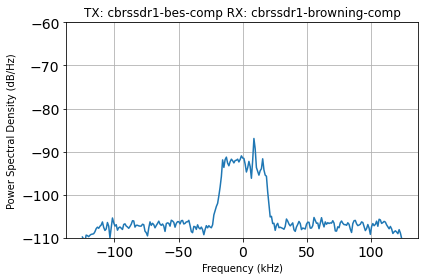

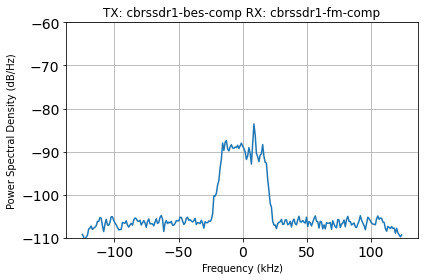

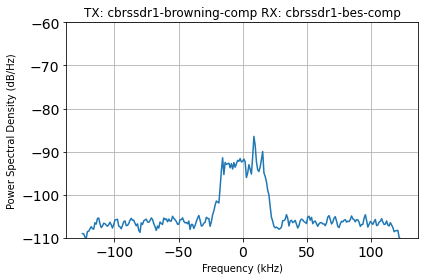

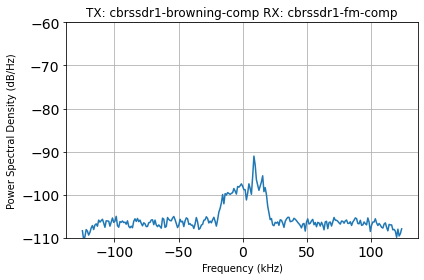

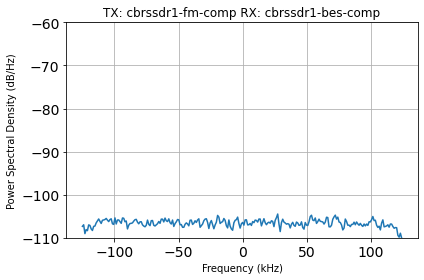

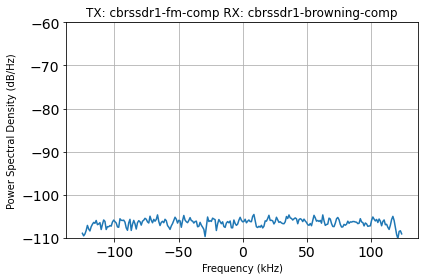

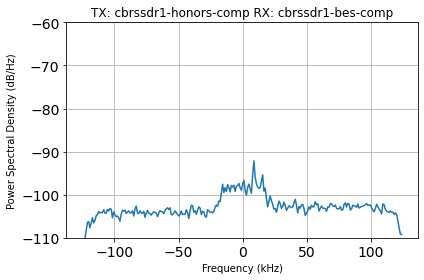

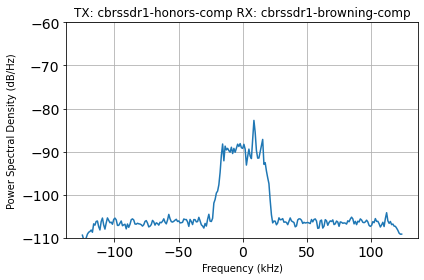

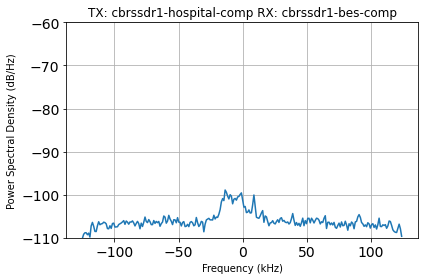

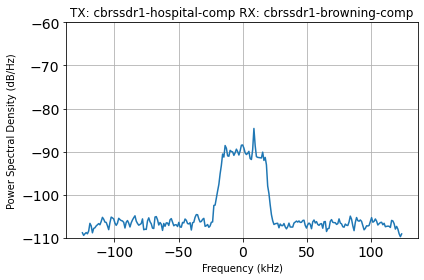

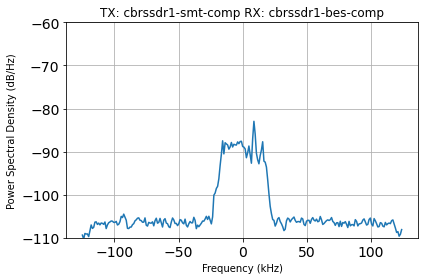

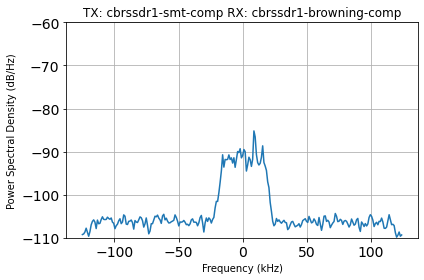

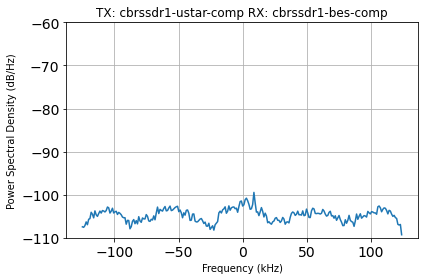

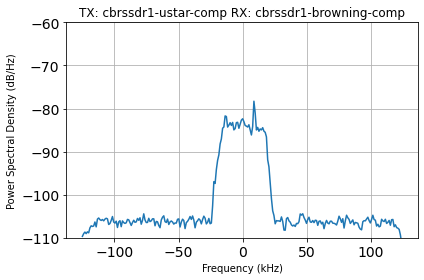

In [6]:
# PSD Plots per Link, repNum = 0 #

plotOnePSDForEachLink(rx_data, txrxloc, samp_rate)

## Calculate Lags

The collected data is parsed in this cell to extract the recieved signals from each link, for each `repNum`. A low pass filter is applied and the index offset (`lagIndex`) is calculated from cross-correlation between the RX signal and the packet preamble. The SNR for each link is also calculated.

Both the offsets and the SNR values are stored in files that are saved to the local directory where this notebook lives on the local host.
* Offset data is stored, numbered by `repNum`, in files entitled `col_#.txt`
* SNR data is stored, numbered by `repNum`, in files entitled `snr_#.txt`

A superimposed plot of each link's PSD plot is produced at the end of the cell.

In this cell, change the range in lines 17, 47, and 55 if there are not 4 repetitions in the experiment.

/Users/cassiejeng/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7237: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
<ipython-input-3-af75c702f780>:71: RuntimeWarning: invalid value encountered in double_scalars
  snr = max((s/n) - 1, 1.0e-5)


 ----- Lag data written to files ----- 
 ----- SNR data written to files ----- 
Packet Length: 4072


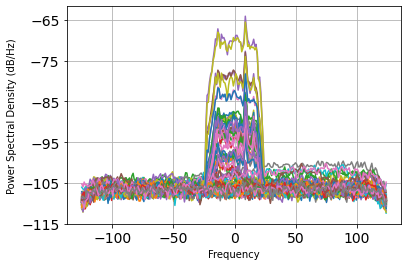

In [7]:
# Calculate Lags #

A = np.sqrt(9/2)
N = 8
alpha = 0.5
Lp = 6

lag_data = []
snr_data = []
peaks_arr = []

for tx in rx_names:
    for rx in rx_names:
        if tx != rx:
            lags_row = []
            snr_row = []
            for repNum in range(4):
                # pick tx - rx pair
                txloc = 'cbrssdr1-' + tx + '-comp'
                rxloc = 'cbrssdr1-' + rx + '-comp'

                rx_data[txloc] = np.vstack(rx_data[txloc])
                rxloc_arr = np.array(txrxloc[txloc])
                rx0 = rx_data[txloc][rxloc_arr==rxloc][repNum]

                # Low Pass Filtering to out_of_band frequency components
                stopband_attenuation = 60.0
                transition_bandwidth = 0.05
                cutoff_norm = 0.15
                filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
                taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
                filtered_rx0 = signal.lfilter(taps, 1.0, rx0)
                
                preambleSignal, pulse = createPreambleSignal(A, N, alpha, Lp)
                lagIndex = crossCorrelationMax(filtered_rx0, preambleSignal, peaks_arr)
                snr, pxx = calculate_SNR(rx0)
                
                lags_row.append(lagIndex)
                snr_row.append(snr)
            lag_data.append(lags_row)
            snr_data.append(snr_row)

lag_data = np.array(lag_data)
snr_data = np.array(snr_data)
off = 4072

for r in range(4):
    file_name = 'col_' + str(r+1) + '.txt'
    with open(file_name,'w') as f:
        for dat in lag_data[:,r]:
            f.write(str(dat) + ',\n')

print(' ----- Lag data written to files ----- ')

for r in range(4):
    file_name = 'snr_' + str(r+1) + '.txt'
    with open(file_name,'w') as f:
        for dat in snr_data[:,r]:
            f.write(str(dat) + ',\n')

print(' ----- SNR data written to files ----- ')

print("Packet Length:", off)

## Setting up the A Matrix

The `A` matrix, outlined in this cell, is built from the relationships between the transmitters and recievers in each link in the experiment. The matrix has a row for each link and a column for each RX name twice. Therefore, the dimensions of `A` are `(num_links, 2*num_nodes)`.

Each link is a `(tx_name, rx_name)` pair.

The first column of `A` is deleted so that there is a reference point for the global time during the estimation process. Since there is no previous reference for the network global time, estimates for each node are drawn in comparison to the first node in the `rx_name` list.

In [8]:
# Setting up the A Matrix #

A = np.zeros((len(links),2*len(rx_names)))

link_num = 0
for link in links:
    tx_num = rx_names.index(link[0])
    rx_num = rx_names.index(link[1])
    A[link_num,tx_num] = 1
    A[link_num,len(rx_names)+tx_num] = 1
    A[link_num,rx_num] = -1
    link_num += 1

A_old = A
A = np.delete(A, 0, axis=1)

print(" ----- A matrix ----- ")
print('Rank (A): ', np.linalg.matrix_rank(A))
print('Shape (A): ', A.shape)

 ----- A matrix ----- 
Rank (A):  13
Shape (A):  (42, 13)


## Finding Peusdo-Inverse of A

The distributed clock time offset estimation uses the linear equation
```
Δ = A * e
```
The peusdo-inverse of `A` is necessary in solving for the estimate vector, `e`.
```
A' * Δ = e
```

In [9]:
# Finding Peusdo-inverse of A #

pinvA = np.linalg.pinv(A)

print(" ----- peusdoinverse A ----- ")

 ----- peusdoinverse A ----- 


## Making the Delta Vectors

The Delta (`Δ`) vectors hold the offset data that was calculated previously and stored in the external files. The `make_delta` function reads the stored files into vector variables for use later.

Add additional function calls and variables in this cell if there are not 4 repetitions in the experiment.

In [10]:
# Making the Delta Vectors #

delta_1 = make_delta(1,links)
delta_2 = make_delta(2,links)
delta_3 = make_delta(3,links)
delta_4 = make_delta(4,links)

## Making the SNR Vectors

The SNR vectors hold the SNR data that was calculated previously and stored in the external files. The `make_snr_vecs` function reads the stored files into vector variables for use later.

Each SNR vector should sum to 1 to serve as a weighted proportion of signal strength compared to the other links. Therefore, each SNR vector is divided by the sum of its elements.

Add additional function calls and variables in this cell if there are not 4 repetitions in the experiment.

In [11]:
# Making the SNR Vectors #

snr_1 = make_snr_vecs(1,links)
snr_2 = make_snr_vecs(2,links)
snr_3 = make_snr_vecs(3,links)
snr_4 = make_snr_vecs(4,links)

snr_1 = snr_1 / (sum(snr_1))
snr_2 = snr_2 / (sum(snr_2))
snr_3 = snr_3 / (sum(snr_3))
snr_4 = snr_4 / (sum(snr_4))

print(sum(snr_1))

[nan]


## Correct Error in Estimates

Because the packets are sent twice during transmission, there is a chance for a "wrap-around" affect that adds an additional packet-length offset to the calculated offset. Without correcting this, the data artificially appears to have significant offset for some links.

The `correct_difference` function checks all offsets in each Δ vector, compared to each other, and corrects outliers by subtracting the "wrap-around" offset.

To see results without correcting for "wrap-around" offset, comment out this section of the code.

The values that were corrected are printed below.

Add additional function calls and variables in this cell if there are not 4 repetitions in the experiment.

In [12]:
# Correct Error in Estimates #

print(' ----- Values to Correct ----- ')
delta_1 = correct_difference(1,delta_1,rx_names,off)
delta_2 = correct_difference(2,delta_2,rx_names,off)
delta_3 = correct_difference(3,delta_3,rx_names,off)
delta_4 = correct_difference(4,delta_4,rx_names,off)

 ----- Values to Correct ----- 
Column 1, Section 0, Index 1 -- -176.0
Column 1, Section 0, Index 3 -- 281.0
Column 1, Section 1, Index 0 -- 319.0
Column 1, Section 1, Index 1 -- -176.0
Column 1, Section 1, Index 2 -- 1676.0
Column 1, Section 1, Index 4 -- 1626.0
Column 1, Section 1, Index 5 -- 1625.0
Column 1, Section 2, Index 0 -- 595.0
Column 1, Section 3, Index 1 -- 1091.0
Column 1, Section 3, Index 2 -- -176.0
Column 1, Section 3, Index 4 -- 1091.0
Column 1, Section 3, Index 5 -- 1090.0
Column 1, Section 4, Index 2 -- -176.0
Column 1, Section 5, Index 2 -- -176.0
Column 1, Section 6, Index 2 -- -176.0
Column 2, Section 0, Index 0 -- 912.0
Column 2, Section 0, Index 1 -- -176.0
Column 2, Section 0, Index 2 -- 944.0
Column 2, Section 0, Index 4 -- 921.0
Column 2, Section 0, Index 5 -- 919.0
Column 2, Section 1, Index 1 -- -176.0
Column 2, Section 2, Index 0 -- 1606.0
Column 2, Section 3, Index 1 -- 1518.0
Column 2, Section 3, Index 2 -- -176.0
Column 2, Section 3, Index 4 -- 1599.0


## Creating Estimate Vectors

The `find_e_vector` function uses the delta variables, `A` matrix, and `A` puesdo-inverse to calculate the estimate time offsets for each receiver.

The function returns:
* `e_i`: the difference between each node i's internal clock and the global clock
* `T_i`: additional delay at each node i before sending the packet
* estimate: concatenated vector `[e_i; T_i]`

Setting the parameter `weighted = 1` in the function will invoke the weighted least squares error method. This method is not optimized yet, but uses the SNR vectors to weight each link in the error analysis, giving higher priority to signals with stronger signal to noise ratios. The default is to have `weighted = 0` to use the regular least squares error method.

Add additional function calls and variables in this cell if there are not 4 repetitions in the experiment.

In [13]:
# Creating Estimate Vectors #

e_est_1, T_est_1, estimate_1 = find_e_vector(delta_1,A,pinvA,rx_names,snr_1,weighted=0)
e_est_2, T_est_2, estimate_2 = find_e_vector(delta_2,A,pinvA,rx_names,snr_2,weighted=0)
e_est_3, T_est_3, estimate_3 = find_e_vector(delta_3,A,pinvA,rx_names,snr_3,weighted=0)
e_est_4, T_est_4, estimate_4 = find_e_vector(delta_4,A,pinvA,rx_names,snr_4,weighted=0)

# e_est_1, T_est_1, estimate_1 = find_e_vector(delta_1,A,pinvA,rx_names,snr_1,weighted=1)
# e_est_2, T_est_2, estimate_2 = find_e_vector(delta_2,A,pinvA,rx_names,snr_2,weighted=1)
# e_est_3, T_est_3, estimate_3 = find_e_vector(delta_3,A,pinvA,rx_names,snr_3,weighted=1)
# e_est_4, T_est_4, estimate_4 = find_e_vector(delta_4,A,pinvA,rx_names,snr_4,weighted=1)

## Printing Results

The `print_results` function displays the above results in an organized format for easy comparison. The first e_estimate in each section should be `0.00000` since it is being used as the reference point for the estimation.

Add additional function calls and variables in this cell if there are not 4 repetitions in the experiment.

In [14]:
# Printing Results #

print_results(1, rx_names, e_est_1, T_est_1)
print('\n ------------------------------ \n')

print_results(2, rx_names, e_est_2, T_est_2)
print('\n ------------------------------ \n')

print_results(3, rx_names, e_est_3, T_est_3)
print('\n ------------------------------ \n')

print_results(4, rx_names, e_est_4, T_est_4)
print('\n ------------------------------ \n')

 ---------- column (repNum) 1 in delta data ---------- 
(~, rx_name ) -----    e_estimate    -----   T_estimate
(~, bes     ) -----  [0.00000000]  ----- [2277.83333333]
(~, browning) -----  [-663.6000000]  ----- [5055.0333333]
(~, fm      ) -----  [-1183.2571429]  ----- [4069.6333333]
(~, honors  ) -----  [-828.7428571]  ----- [4791.0333333]
(~, hospital) -----  [-65.5428571]  ----- [2118.6333333]
(~, smt     ) -----  [-415.5714286]  ----- [2250.8333333]
(~, ustar   ) -----  [-673.2857143]  ----- [2429.8333333]

 ------------------------------ 

 ---------- column (repNum) 2 in delta data ---------- 
(~, rx_name ) -----    e_estimate    -----   T_estimate
(~, bes     ) -----  [0.00000000]  ----- [4929.03333333]
(~, browning) -----  [232.54285714]  ----- [4218.23333333]
(~, fm      ) -----  [525.88571429]  ----- [3222.83333333]
(~, honors  ) -----  [-31.5142857]  ----- [4235.6333333]
(~, hospital) -----  [983.74285714]  ----- [3659.83333333]
(~, smt     ) -----  [-126.0571429]  ----- [4

## Least Square Error

The least square error method is used to analyze the estimate results in comparison to the offset calculations. The error should be Gaussian and the squared error histograms should be comparable to the [Chi Squared Distribution](https://www.stat.berkeley.edu/~stark/Java/Html/SampleChi.htm).

The `least_sq_error` function calculates the least square error for each link, by `repNum`, and plots the error by link number. It also produces histograms of the errors and squared errors for each `repNum`. Finally, it calculates the root mean squared error (RMSE) for each `repNum`.

Add additional function calls and variables in this cell if there are not 4 repetitions in the experiment.

 ----- Plotting Link Error for Column 1 ----- 


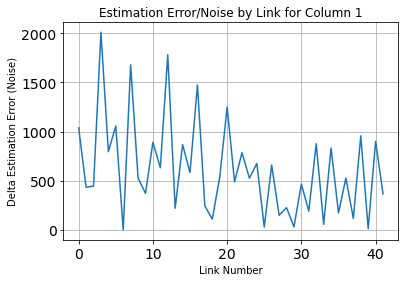

 ----- Histogram Link error for Column 1 ----- 


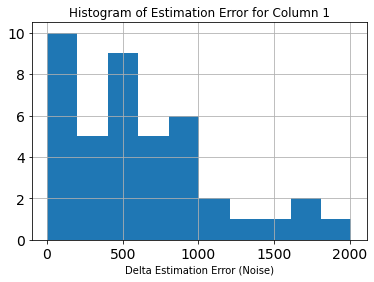

 ----- Histogram Link Squared Error for Column 1 ----- 


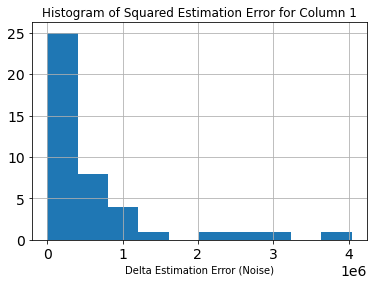

 ----- Root Mean Squared Error for Column 1 ----- 
788.1357881238118


 ----- Plotting Link Error for Column 2 ----- 


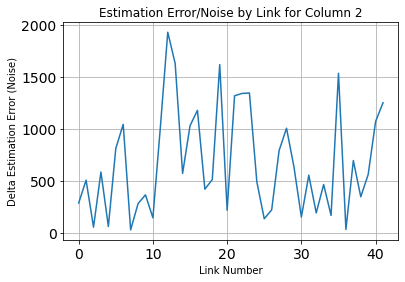

 ----- Histogram Link error for Column 2 ----- 


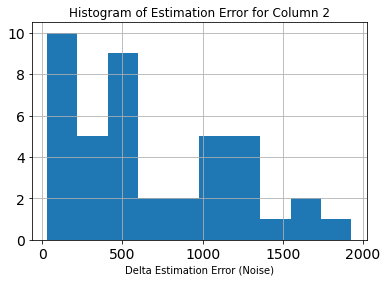

 ----- Histogram Link Squared Error for Column 2 ----- 


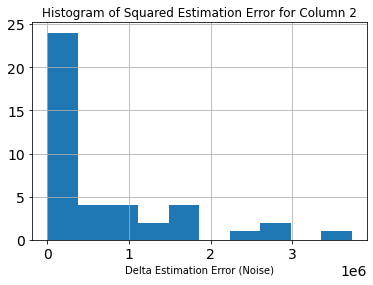

 ----- Root Mean Squared Error for Column 2 ----- 
848.7895118859141


 ----- Plotting Link Error for Column 3 ----- 


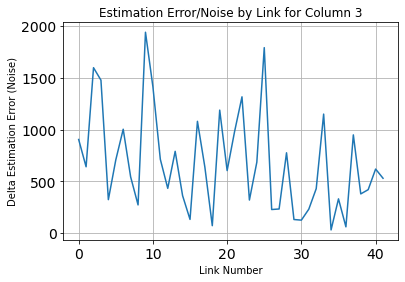

 ----- Histogram Link error for Column 3 ----- 


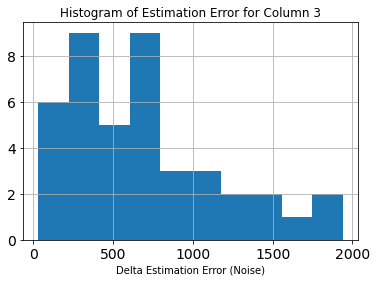

 ----- Histogram Link Squared Error for Column 3 ----- 


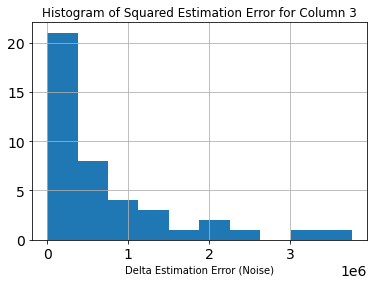

 ----- Root Mean Squared Error for Column 3 ----- 
834.7129524804013


 ----- Plotting Link Error for Column 4 ----- 


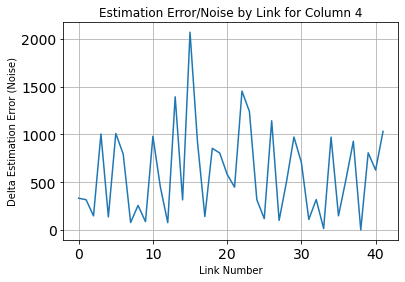

 ----- Histogram Link error for Column 4 ----- 


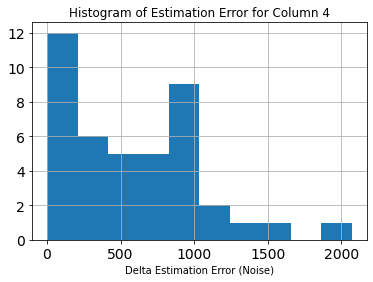

 ----- Histogram Link Squared Error for Column 4 ----- 


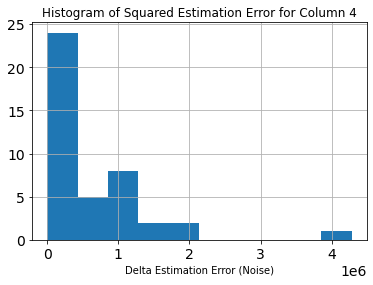

 ----- Root Mean Squared Error for Column 4 ----- 
762.4973639596084




In [15]:
# Least Square Error #

RMSE_1,error_1 = least_sq_error(1,estimate_1,delta_1,A,links)
RMSE_2,error_2 = least_sq_error(2,estimate_2,delta_2,A,links)
RMSE_3,error_3 = least_sq_error(3,estimate_3,delta_3,A,links)
RMSE_4,error_4 = least_sq_error(4,estimate_4,delta_4,A,links)

## Plotting SNR Error

The `plot_snr_error` function plots the error vs. inverse of the SNR for each link. Observing how the SNR ratio is related to the error is helpful in optimizing the weighted least squares method.

Add additional function calls and variables in this cell if there are not 4 repetitions in the experiment.

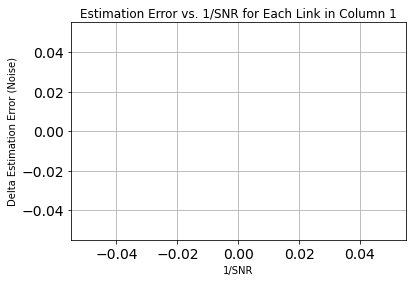

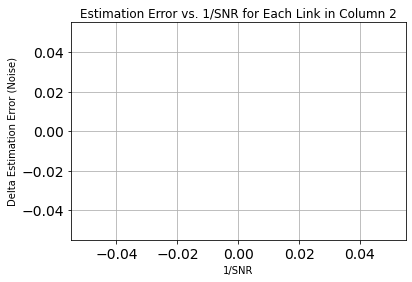

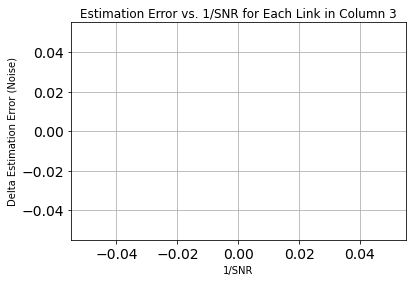

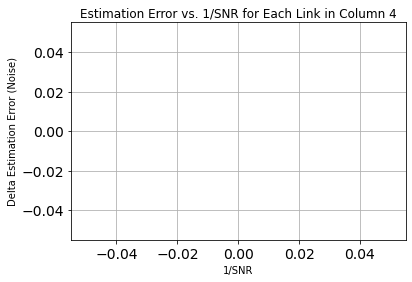

In [16]:
# Plotting SNR Error #

inv_snr_1 = plot_snr_error(snr_1,error_1,1)
inv_snr_2 = plot_snr_error(snr_2,error_2,2)
inv_snr_3 = plot_snr_error(snr_3,error_3,3)
inv_snr_4 = plot_snr_error(snr_4,error_4,4)

## Printing Error Results

This cell prints the RMSE for each `repNum` (Column), as well as plots each together on a scatter plot and a bar chart to show the comparison. 

Add additional function calls and variables in this cell if there are not 4 repetitions in the experiment.

column 1 ----- column 2 ----- column 3 ----- column 4
788.1358 ----- 848.7895 ----- 834.7129 ----- 762.4974

RMSE ratio between columns:  0.8983350995741582


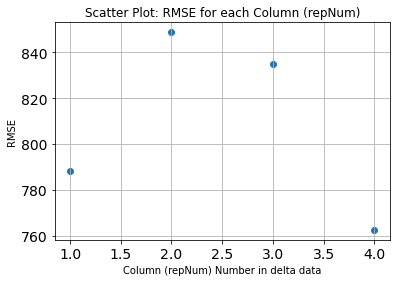

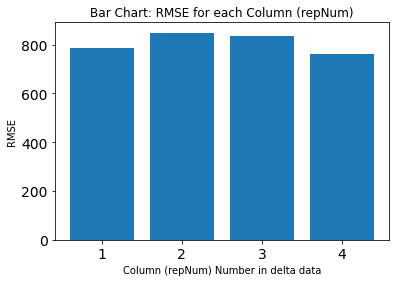

In [17]:
# Printing Error Results #

RMSE_1 = round_string(RMSE_1)
RMSE_2 = round_string(RMSE_2)
RMSE_3 = round_string(RMSE_3)
RMSE_4 = round_string(RMSE_4)

RMSE_ratio = min([RMSE_1, RMSE_2, RMSE_3, RMSE_4])/max([RMSE_1, RMSE_2, RMSE_3, RMSE_4])

print(Fore.RED + "column 1 ----- column 2 ----- column 3 ----- column 4" + Style.RESET_ALL)
print(str(RMSE_1) + ' ----- ' + str(RMSE_2) + ' ----- ' + str(RMSE_3) + ' ----- ' + str(RMSE_4))
print('\nRMSE ratio between columns: ', RMSE_ratio)

plt.scatter(np.array([1,2,3,4]),np.array([RMSE_1,RMSE_2,RMSE_3,RMSE_4]))
plt.grid()
plt.xlabel('Column (repNum) Number in delta data')
plt.ylabel('RMSE')
plt.title('Scatter Plot: RMSE for each Column (repNum)')
plt.show()

plt.bar(np.array(['1','2','3','4']),np.array([RMSE_1,RMSE_2,RMSE_3,RMSE_4]))
plt.xlabel('Column (repNum) Number in delta data')
plt.ylabel('RMSE')
plt.title('Bar Chart: RMSE for each Column (repNum)')
plt.show()

## Example Results

#### Example Data: 2/16
* Uncorrected
    * RMSEs: 3.544486 ----- 521.1848 ----- 522.2963 ----- 4.148067
    * Ratio: 0.0067863509659172394
* Corrected
    * RMSEs: 3.544486 ----- 3.811383 ----- 3.450722 ----- 4.148067
    * Ratio: 0.8318867559275199
* Corrected, Weighted
    * RMSEs: 3.705443 ----- 4.158776 ----- 3.703704 ----- 4.68900
    * Ratio: 0.7898694137438025

#### Example Data: 1/20
* Uncorrected
    * RMSEs: 876.1062 ----- 521.5538 ----- 928.9545 ----- 1145.608
    * Ratio: 0.45526375514137474
* Corrected
    * RMSEs: 3.629246 ----- 3.262513 ----- 3.947286 ----- 4.431655
    * Ratio: 0.736183886155398
* Corrected, Weighted
    * RMSEs: 
    * Ratio: 